# Image Transformation: Projective transformations

The previous work book looked at affine transformations. They are a special type of linear transformation, in which on preserves straight lines and planes. A set of parallel lines in an image will be parallel to each other after the transformation.

This is great for doing things like rotating images or moving vectors, but in many of the images we will come across it is important to also do projective transformations. Projective transformations are those that correct for a perspective - where a perspective projection is when three dimensional objects are projected on a picture plane. Clearly this relates to images, and its effect is obvious, everyone known that when one sees the effect when distant objects appear smaller than nearer objects in an image.

As before we will end up doing this the hard way, where libraries exist for the tasks. However this is a learning exercise to gain more familiarity with:

1. Linear algebra
2. Multivariate calculus
3. Optimization and solving techniques
4. Latex and Jupyter notebooks

As always, start with getting the libraries.

In [1]:
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import math
import time
import timeit
from scipy.linalg import null_space

## Preparing the image
As before we need to get the image. This time the image is from the robot, rather than from the web, but we use a similar method to view it. We convert it to grayscale, and then print it out.

(1080, 1920)


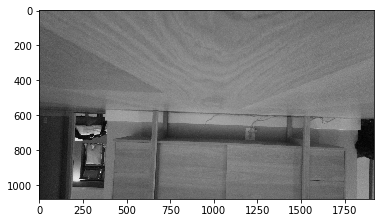

In [2]:
# define the file
filename = "floorimage2.jpg"

# open the image, and convert to grayscale
raw_img = Image.open(filename).convert('LA')

# make image into a numpy array, strip out only the 1st layer
img = np.array(raw_img)[:,:,0]

# find the size
print(img.shape)
# make sure that we are plotting inline
%matplotlib inline

# make a function for plotting the images
def plotimg(img):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.set_aspect(aspect=1)
    plt.show()

# plot the image to make sure we have something sensible
plotimg(img)

The image is upside down, so first up, we need to rotate it. Although we have done the basics before, this time we just use PIL. Its as simple as adding a ".rotate(180)", where the 180 in the brackets is just the angle you would like to rotate by. We also time it, and see that the time is significantly shorter than the time it took on the affine notebook previously.

Wall time: 124 ms
1080 480


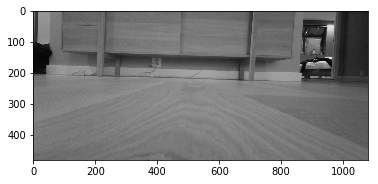

In [3]:
# open the image, and convert to grayscale
%time raw_img = Image.open(filename).convert('LA').rotate(180)

# downsample the image to a quarter of the size
scale = 4
width, height = img.shape
wight = int(round(width/scale))
height = int(round(height/scale))
raw_ds_img = raw_img.resize((width, height), Image.ANTIALIAS)

# make image into a numpy array, strip out only the 1st layer
ds_img = np.array(raw_ds_img)[:,:,0]

# pring the new dimensions
print(width, height)

# plot the image
plotimg(ds_img)

Now we can start to see the issue. The floor in the foreground is significantly larger than the background. The camera is attached to the robot, which is level on the floor. Despite this, the image appears to have a significant slope down to the right hand side. We see this in the "horizon", which is the skirting board. The floor boards, which are parallel when viewed from above. However they converge to an infinity point. This is due to the perspective effect. Both would will need to be adjusted.

## Theory

Before we covered the affine transformations in homogeneous coordinates. The transformation is in the form:

\begin{equation*}
\begin{bmatrix}
x'_{n}\\
y'_{n} \\
1 \\
p_{n}
\end{bmatrix}  =  \mathbf{T} \begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

where $x'_{n}$ and $y'_{n}$ are the transformed coordinates of $x_{n}$ and $y_{n}$ respectively, which are the coordinates of the $n^{th}$ pixel of intensity $p_{n}$, and $\mathbf{T}$ is the transformation matrix. What would traditionally be the $z_{n}$ and $z'_{n}$, are both equal to one.

The transformation matrix included rotation, translation and shear in the case showed before. This time we can present the full generalised transformation matrix in the from: 

\begin{equation*}
\mathbf{T}  =  \begin{bmatrix}
a_{1} & a_{2} & b_{1} & 0\\
a_{3} & a_{4} & b_{2} & 0\\
c_{1} & c_{2} & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

where $a_{1}$ to $a_{4}$ are connected with rotation, $b_{1}$ and $b_{2}$ with translation, $a_{2}$ and $a_{3}$ with shear, and $a_{1}$ and $a_{4}$ with scaling. Differently from before, we now have $c_{1}$ and $c_{2}$ which are where zero for the affine transformation, but are the projection elements of the transformation matrix.

To illustrate the difference we have can plot some pixel centers and see what happens. Let us start by defining the image as a 3 by 3 set of pixel centers, and define our plotting function.

In [4]:
# define the centre points for each pixel
pix_array = np.array([[0, 1, 0, 1, 0, 1, 2, 2, 2],
                      [0, 0, 1, 1, 2, 2, 2, 0, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1]])

def pixelcenterplot(pix_array):
    # set up the plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # plot them with the area between filled in
    for j in list(range(pix_array.shape[1])):
        ax.plot(pix_array[0,j], pix_array[1,j],'o')

    # add some grid lines
    major_ticks = np.arange(-2, 5, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)

    # Set grid to use minor tick locations. 
    ax.grid(which='minor', alpha=0.1)
    ax.grid(which='major', alpha=0.7)
    plt.show()

We can now look again at rotation of the pixels by 45 degrees.

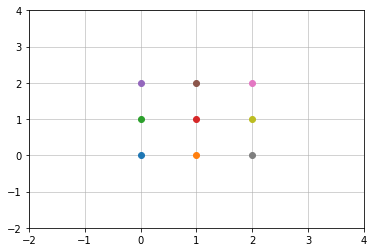

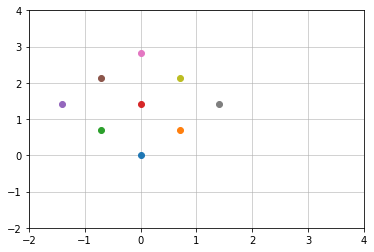

In [5]:
# rotation angle
theta = 45
theta_rad = math.radians(theta)
# define the rotation matrix
T_rot = np.array([[math.cos(theta_rad), -math.sin(theta_rad),0,0],
                  [math.sin(theta_rad), math.cos(theta_rad),0,0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

rot_pix_array = T_rot @ pix_array

# plot the orginal and the rotated pixel centers
pixelcenterplot(pix_array)
pixelcenterplot(rot_pix_array)


All as expected. Lets look at the matrix of points again, in the homogeneous coordinates, where the columns are the homogeneous coordinates for each pixel.

In [6]:
print(np.around(rot_pix_array, decimals=1))

[[ 0.   0.7 -0.7  0.  -1.4 -0.7  0.   1.4  0.7]
 [ 0.   0.7  0.7  1.4  1.4  2.1  2.8  1.4  2.1]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1. ]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1. ]]


As we see, the homogeneous component is equal to 1, before and after the transformation. Lets do the same for projection transformation matrix, with $c_{1}$ and $c_{2}$ both equal to 0.5.

In [7]:
# define the projection matrix
T_pro = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0.25, 0.25, 1, 0],
                  [0, 0, 0, 1]])

# make the transformation
pro_pix_array = T_pro @ pix_array
print(np.around(pro_pix_array, decimals=1))


[[0.  1.  0.  1.  0.  1.  2.  2.  2. ]
 [0.  0.  1.  1.  2.  2.  2.  0.  1. ]
 [1.  1.2 1.2 1.5 1.5 1.8 2.  1.5 1.8]
 [1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


Here we clearly see that the homogeneous component is not still 1. This means the pixels are no longer being viewed from the same perspective. Now with transformation of perspective we have something more similar to this:

\begin{equation*}
\begin{bmatrix}
\alpha_{n}\\
\beta_{n} \\
\gamma_{n} \\
p_{n}
\end{bmatrix}  =  \mathbf{T} \begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

However, the fix is simple. For us to map it back to the real plane, we must make a homogeneous divide - also know as a perspective divide, to get the z component back to 1.

\begin{equation*}
\begin{bmatrix}
x'_{n}\\
y'_{n} \\
1_{n} \\
p_{n}
\end{bmatrix} = \begin{bmatrix}
\frac{\alpha_{n}}{\gamma_{n}}\\
\frac{\beta_{n}}{\gamma_{n}} \\
\frac{\gamma_{n}}{\gamma_{n}} \\
p_{n}
\end{bmatrix}  = \frac{1}{\gamma_{n}} \mathbf{T} \begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

We do this by cycling through each pixel and then dividing the x and y coordinate by the z component for that pixel:

[[0.  0.8 0.  0.7 0.  0.6 1.  1.3 1.1]
 [0.  0.  0.8 0.7 1.3 1.1 1.  0.  0.6]
 [1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


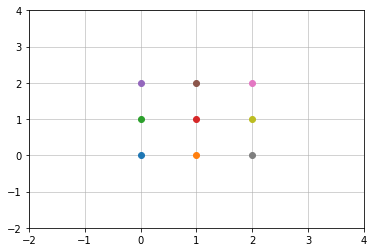

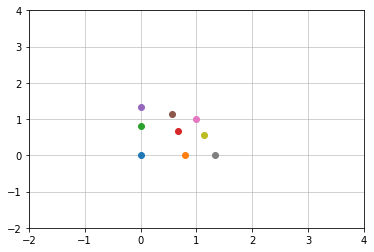

In [8]:
# make the z coordinate 1 by cycling through each pixel
for n in list(range(pro_pix_array.shape[1])):
    pro_pix_array[0, n] = pro_pix_array[0, n] / pro_pix_array[2, n]
    pro_pix_array[1, n] = pro_pix_array[1, n] / pro_pix_array[2, n]
    pro_pix_array[2, n] = pro_pix_array[2, n] / pro_pix_array[2, n]

# print out the coordinates to check the z is 1    
print(np.around(pro_pix_array, decimals=1))

# plot the orginal and the rotated pixel centers
pixelcenterplot(pix_array)
pixelcenterplot(pro_pix_array)

However if we were given a set of points in the original image, and know where we want them to translate to on a new corrected image, how can we calculate the transformation matrix. It might be the combination of a number of different translations, such as shear with rotation, scaling and perspective.

So lets think about this. We have the start coordinates, and the end coordinates, such that the transformation matrix is the unknown:

\begin{equation*}
\begin{bmatrix}
x'_{n}\\
y'_{n} \\
1 \\
p_{n}
\end{bmatrix}  = \frac{1}{\gamma_{n}} \mathbf{T} \begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

We can write the transformation matrix as: 

\begin{equation*}
\mathbf{T} = \begin{bmatrix}
t_{11} & t_{12} & t_{13} & 0\\
t_{21} & t_{22} & t_{23} & 0\\
t_{31} & t_{32} & t_{33} & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

So we can say that each point of correspondence, gives us two constraints, thus for the $n^{th}$ point of reference:

\begin{equation*}
x'_{n} = \frac{\alpha_{n}}{\gamma_{n}} = \frac{t_{11} x + t_{12} y + t_{13}}{t_{31} x + t_{32} y + t_{33}}
\end{equation*}

\begin{equation*}
y'_{n} = \frac{\beta_{n}}{\gamma_{n}} = \frac{t_{21} x + t_{22} y + t_{23}}{t_{31} x + t_{32} y + t_{33}}
\end{equation*}

we can now rearrange the two equations above, by multiplying out the fractions:

\begin{equation*}
x'_{n}(t_{31} x + t_{32} y + t_{33}) = t_{11} x + t_{12} y + t_{13}
\end{equation*}

\begin{equation*}
y'_{n}(t_{31} x + t_{32} y + t_{33}) = t_{21} x + t_{22} y + t_{23}
\end{equation*}

This can be further rearrange and made into to a matrix multiplication:

\begin{equation*}
\begin{bmatrix}
x_{n} & y_{n} & 1 & 0 & 0 & 0 & -x'_{n}x_{n} & -x'_{n}y_{n} & -x'_{n} \\
0 & 0 & 0 & x & y & 1 & -y'_{n}x_{n} & -y'_{n}y_{n} & -y'_{n}
\end{bmatrix} \mathbf{t} = 0
\end{equation*}

where $\mathbf{t}$ is the matrix $\mathbf{T}$ written as a vector:

\begin{equation*}
\mathbf{t} = \begin{bmatrix}
t_{11} & t_{12} & t_{13} & t_{21} & t_{22} & t_{23} & t_{31} & t_{32} & t_{33}
\end{bmatrix} ^T
\end{equation*}

Thus for a total of $N$ points we construct a matrix of correspondence $\mathbf{C}$, a $N$ by 9 matrix:

\begin{equation*}
\begin{bmatrix}
x_{1} & y_{1} & 1 & 0 & 0 & 0 & -x'_{1}x_{1} & -x'_{1}y_{1} & -x'_{1} \\
0 & 0 & 0 & x & y & 1 & -y'_{1}x_{1} & -y'_{1}y_{1} & -y'_{1}\\
x_{2} & y_{2} & 1 & 0 & 0 & 0 & -x'_{2}x_{2} & -x'_{2}y_{2} & -x'_{2} \\
0 & 0 & 0 & x & y & 1 & -y'_{2}x_{2} & -y'_{2}y_{2} & -y'_{2}\\
& & & &...& & & & \\
& & & &...& & & &\\
x_{N} & y_{N} & 1 & 0 & 0 & 0 & -x'_{N}x_{N} & -x'_{N}y_{N} & -x'_{N} \\
0 & 0 & 0 & x & y & 1 & -y'_{N}x_{N} & -y'_{N}y_{N} & -y'_{N}
\end{bmatrix} \mathbf{t} = 0
\end{equation*}

If the number of points of correspondence $N$ is 4, then the solution of $\mathbf{t}$ is the one dimensional null space of  $\mathbf{C}$. We can of course use a larger number of points, finding t using Singular Value Decomposition (SVD) of C, where t is the column of V corresponding to the smallest singular value. Of course as this approach is a least squares fit, then the smallest singular value of the column of V would be zero for the case where the data were exact.  

## Putting into practice

The images we have shown above for the robot are not the best to see the effect of translation. We actually want something that can show this to a much greater degree. Thus we introduce a new photo, with a clear perspective, and one that can be changed significantly to see the effect of correction.

Lets get it from the web, and plot it.

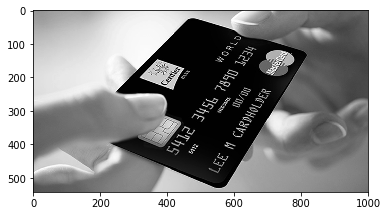

In [9]:
# define the url of the image of interest and download the image
url = "https://d3sezmnsirbd9l.cloudfront.net/wp-content/uploads/2018/04/16150346/centier-credit-cards.jpg"

response = requests.get(url)

# open the image, and convert to grayscale
raw_img = Image.open(BytesIO(response.content)).convert('LA')

# make image into a numpy array, strip out only the 1st layer
img = np.array(raw_img)[:,:,0]
plotimg(img)

To simplify the transformation, we want to map over the image some red lines that represent the corners of the card, and clearly show us the original location of the credit card. This time we will just find the corners by eye, but in a later notebook we will find the edges with edge detection. Again, this is going to be massively useful for our robot!

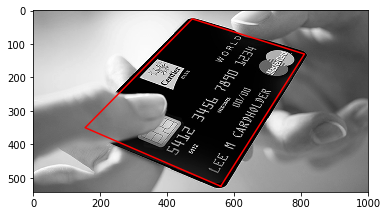

In [10]:
# define the corners of the credit card
corners_plot = np.array([[560, 810, 475, 155, 560],
                    [525, 130, 25, 350, 525],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])


# plot the image, with an red line over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='gray')
# plot the lines
ax.plot(corners_plot[0,:], corners_plot[1,:], 'r')
ax.set_aspect(aspect=1)
plt.show()

We want to be able to transform the red box so that it is a rectangle with text in the x direction only, and the correct way up. We know that the aspect ratio of a credit card, as the size of the sides are well defined - 85.60 mm for the long side and 53.98 mm for the short side. So we can also draw out some points which represent where the card should end up.

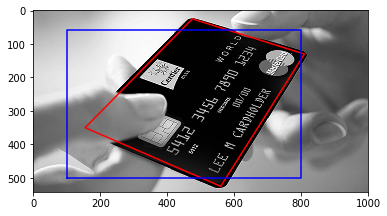

In [11]:
aspect_ratio = 85.60/53.98
corner_1 = corners_plot[0:2,0]
corner_4 = corners_plot[0:2,3]
width = np.linalg.norm(corner_1 - corner_4)
length = width * aspect_ratio

x0 = 100
y0 = 500
new_corners_plot = np.array([[x0, x0 + length, x0 + length, x0, x0],
                        [y0, y0, y0 - width, y0 - width, y0],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1]])

# plot the image, with an red line over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='gray')
# plot the lines
ax.plot(corners_plot[0,:], corners_plot[1,:], 'r')
ax.plot(new_corners_plot[0,:], new_corners_plot[1,:], 'b')
ax.set_aspect(aspect=1)
plt.show()

Now lets apply the theory above to get the transformation matrix to move the red box to the blue box.

In [12]:
# remove the last column of the corner_plot matrix, which is a repete of the first point
corners = np.delete(corners_plot, 4, 1)

# do the same for the new_corners_plot
new_corners = np.delete(new_corners_plot, 4, 1)

# get the shape of the reference points matrix, to get the number of reference points
D, npoints = new_corners.shape

# make an empty matrix for the matrix of correspondence
C = np.zeros((2*npoints, 9))

# cycle through all the points to construct the C matrix
for n in list(range(npoints)):
    # points on the original image
    xo_n = corners[0, n]
    yo_n = corners[1, n]
    # points on the transformed image
    xd_n = new_corners[0, n]
    yd_n = new_corners[1, n]
    # populating the C matrix
    C[2*n,     :] = [xo_n, yo_n, 1,    0,    0, 0, -xd_n*xo_n, -xd_n*yo_n, -xd_n]
    C[2*n + 1, :] = [   0,    0, 0, xo_n, yo_n, 1, -yd_n*xo_n, -yd_n*yo_n, -yd_n]

# solve C.t = 0 to find t
# if the number of corresponding points is equal to 4 use null space
if npoints == 4:
    t = null_space(C)
# else if greater than 4 use SVD, which will be added another time

# reconstruct T
T = t.reshape(3,3)
bottom = np.array([0,0,0])
side = np.array([[0],[0],[0],[1]])
T = np.vstack((T,bottom))
T = np.hstack((T,side))


Quick check that its doing the right thing, lets take the corners from the original image, and apply the transform T.

In [13]:
# make the transformation of the orginal corners
pro_corners = (T @ corners)

# make the coordinates homogenious
for n in list(range(pro_corners.shape[1])):
    pro_corners[0, n] = pro_corners[0, n] / pro_corners[2, n]
    pro_corners[1, n] = pro_corners[1, n] / pro_corners[2, n]
    pro_corners[2, n] = pro_corners[2, n] / pro_corners[2, n]

# the original corners with transformation matrix applied    
print(np.around(pro_corners, decimals=0))
# the goal corners we want it to be
print(np.around(new_corners, decimals=0))

[[100. 800. 800. 100.]
 [500. 500.  59.  59.]
 [  1.   1.   1.   1.]
 [  1.   1.   1.   1.]]
[[100. 800. 800. 100.]
 [500. 500.  59.  59.]
 [  1.   1.   1.   1.]
 [  1.   1.   1.   1.]]


We get the right answer, so positive sign we are doing the right thing. Lets apply this to the image, and see what we get. First we convert the image to homogenous coordinates.

In [14]:
# get out the maximum number of pixels in x and y direction
ymax, xmax = img.shape

# get the total number of pixels N
N = ymax * xmax

# create an empty matrix for the for of 4 rows and N columns
img_matrix = np.empty((4, N))

# introduce the index, which is subscript n in the vector in the text above
index = 0

# now cycle through the full images to fill [x, y, 1, p]^T
for i in list(range(ymax)): # cycle through each row
    for j in list(range(xmax)): # cycle through each column
        p = img[i,j] # extract pixel intensity
        img_matrix[3,index] = p
        img_matrix[2,index] = 1
        img_matrix[1,index] = i # y-cord.
        img_matrix[0,index] = j # x-cord.
        index += 1


Then we apply the transform

In [15]:
# apply a transform to the data in matrix form
corrected_image_matrix = T @ img_matrix

# create an empty array full of NaN values for the corrected imgage
corrected_img = np.empty((ymax, xmax))
corrected_img[:] = np.nan

# cycle through the full number of pixels
for n in list(range(N)):
    # get the x and y coordinates, correcting for non unity z coordinate
    x = int(round(corrected_image_matrix[0, n]/corrected_image_matrix[2, n]))
    y = int(round(corrected_image_matrix[1, n]/corrected_image_matrix[2, n]))
    # get the pixel intensity
    p = corrected_image_matrix[3, n]
    # only accept pixels that are in the orginal span of the image ymax and xmax
    if  x < xmax and y < ymax and x >= 0 and y >= 0:
        corrected_img[y, x] = p

We now want to print out both the original image, and the corrected image.

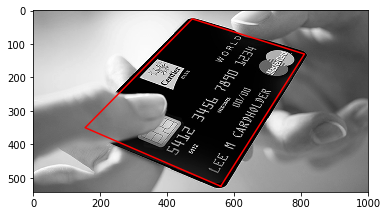

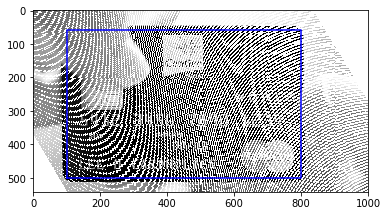

In [16]:
# plot the orginal image, with an red line over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='gray')
# plot the lines
ax.plot(corners_plot[0,:], corners_plot[1,:], 'r')
ax.set_aspect(aspect=1)
plt.show()

# plot the corrected image, with a blue line for the target over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(corrected_img, cmap='gray')
# plot the lines
ax.plot(new_corners_plot[0,:], new_corners_plot[1,:], 'b')
ax.set_aspect(aspect=1)
plt.show()

As with the affine image transformation, we have a large number of missing pixels. It has drastically changed the sharpness of the image. At the resolution plotted above, it looks even worse because of aliasing issues. However, the we can still see the that the perspective of the image has now been changed to what we want - the text is running from left to right. Lets look at a close up of the numbers to see this is really true. 

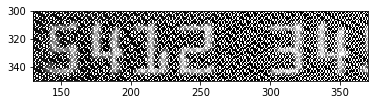

In [17]:
plt.figure()
plt.imshow(corrected_img, cmap='gray')
plt.xlim(130, 370)
plt.ylim(350, 300)
plt.show()

Awesome. The perspective really has been changed. You can see the first numbers "5412 34" well enough, but importantly not clearly enough! We really need to fix that problem. I think this will be the subject of the next notebook.